# Examples of Using the Huggingface Model Hub

### Code Preamble

In [479]:
import numpy as np
import pandas as pd
import requests

from bs4 import *
from torch import nn


In [415]:
def scrape_text(url):
    url = url
    res = requests.get(url)
    html_page = res.text

    # Parse the source code using BeautifulSoup
    soup = BeautifulSoup(html_page, 'html.parser')

    # Extract the plain text content
    text = soup.get_text()
    return text

## Huggingface 

### The Huggingface Hub

- Like Github, but for LLMs and other large neural nets
- Models, datasets, apps
- Take a look: [https://huggingface.co/](https://huggingface.co/)

## Fine-Tuned Classifiers: Toxicity Detection with Pre-Trained RoBERTa

- You've trained your own toxicity classifier
- Next we'll use a classifier that was trained by someone else, **finetuning** an LLM
    - Take a look: [toxicity classifier](https://huggingface.co/s-nlp/roberta_toxicity_classifier) by [S-NLP](https://huggingface.co/s-nlp)

In [416]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [417]:
# load tokenizer and model weights
tokenizer = RobertaTokenizer.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier')
model = RobertaForSequenceClassification.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier')

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [418]:
# prepare the input
batch = tokenizer.encode('you are amazing', return_tensors='pt')

# inference
model(batch)

SequenceClassifierOutput(loss=None, logits=tensor([[ 4.6567, -4.9115]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

### Getting the Predictions Out

In [419]:
model(batch).logits #log-odds

tensor([[ 4.6567, -4.9115]], grad_fn=<AddmmBackward0>)

In [420]:
def get_label_from_prediction(logits):
    probabilities = nn.functional.sigmoid(logits) # Run sigmoid on the logits to turn them to probabilities
    non_toxic_prob = probabilities[0][0].detach().numpy() #We get the first probability value
    if non_toxic_prob < 0.5: # Check if probability is less than zero
        return "toxic"
    else:
        return "not toxic"


In [421]:
def txt_to_prediction_to_label(text, model):
    batch = tokenizer.encode(text, return_tensors='pt') #Tokenize your input text
    prediction = model(batch) #Use model to predict
    return get_label_from_prediction(prediction.logits) #Extract label from predictions

In [422]:
txt_to_prediction_to_label("fuck you you fucking fuck", model)

'toxic'

In [423]:
txt_to_prediction_to_label("here come the feminazis again", model)

'toxic'

In [424]:
txt_to_prediction_to_label("Adolf Hitler was a great guy", model)

'not toxic'

In [425]:
txt_to_prediction_to_label("We'll take you behind the sauna", model)

'not toxic'

In [426]:
txt_to_prediction_to_label("Je te deteste", model)

'not toxic'

In [427]:
txt_to_prediction_to_label("Yo te odio", model)

'not toxic'

In [428]:
txt_to_prediction_to_label("White pride forever", model)

'not toxic'

In [429]:
txt_to_prediction_to_label("1488", model)

'not toxic'

### Looping through predictions

In [430]:
from nltk.tokenize import sent_tokenize

In [431]:
text_tiqqun = scrape_text('https://theanarchistlibrary.org/library/tiqqun-the-cybernetic-hypothesis.muse')
sents_tiqqun = sent_tokenize(text_tiqqun)

In [439]:
from tqdm import tqdm

In [433]:
%time

not_toxic = []
toxic = []
for sent in tqdm(sents_tiqqun):
    pred = txt_to_prediction_to_label(sent, model)
    preds.append(pred)
    if pred == 'toxic':
        toxic.append(sent)
    else:
        not_toxic.append(sent)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


100%|█████████████████████████████████████████████████| 856/856 [01:07<00:00, 12.60it/s]


In [435]:
len(toxic)

5

In [436]:
toxic

['These are the murderers of Time, the crusaders of Sameness, the lovers of fatality.',
 'The capitalist is a conqueror, and the conqueror is a monster, a centaur.',
 'And there are some that are just too strong... that threaten to break shit.',
 'Firstly: I cum perversely.',
 'They must be absorbed, eliminated.']

In [437]:
text_anarkata = scrape_text('https://theanarchistlibrary.org/library/anarkata.muse')

In [438]:
def loop_for_toxicity(sents):
    not_toxic = []
    toxic = []
    for sent in tqdm(sents):
        pred = txt_to_prediction_to_label(sent, model)
        preds.append(pred)
        if pred == 'toxic':
            toxic.append(sent)
        else:
            not_toxic.append(sent)
    return toxic, not_toxic, preds

toxic_anarkata, not_toxic_anarkata, preds_anarkata = loop_for_toxicity(sent_tokenize(text_anarkata))

100%|█████████████████████████████████████████████████| 442/442 [00:30<00:00, 14.45it/s]


In [440]:
print(len(toxic_anarkata))
print(len(not_toxic_anarkata))

33
409


In [441]:
toxic_anarkata[:3]

['Black captives in the gender segregated hold of slave ships foraged queer relationships with one another.',
 'Black trans people continued to transgress the colonial gender binaries imposed by white colonizers.',
 'This means Black labor in the Third and Fourth Worlds; this means prison labor, domestic labor, sex work, emotional labor, and other forms of Black labor that are elicited largely from femes, prisoners, QTGNC people, and others in the Black community.']

### Project Idea: Patterns of Toxicity

- Demonstrate patterns in what kind of text is deemed toxic and what is not
    - For example: LLMs vs Black Radicalism
- Produce some data visualizations and showcase examples

## Open Source Zero-Shot Classification with BART

- Sometimes we don't know what classes we want to use
- We can entrust the LLM to interpret the classes
    - Zero-shot and few-shot 

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")


In [ ]:
sequence_to_classify = "I hate the police"
candidate_labels = ['extremist', 'non-extremist']
classifier(sequence_to_classify, candidate_labels)

In [ ]:
sequence_to_classify = "I love the police"
candidate_labels = ['extremist', 'non-extremist']
classifier(sequence_to_classify, candidate_labels)

In [ ]:
sequence_to_classify = "I hate pizza"
candidate_labels = ['extremist', 'non-extremist']
classifier(sequence_to_classify, candidate_labels)

In [ ]:
sequence_to_classify = "I hate the police. Just kidding!"
candidate_labels = ['extremist', 'non-extremist']
classifier(sequence_to_classify, candidate_labels)

## Sequence Similarity & Clustering Using Sentence Transformers

- Sometimes we want to look at the similarity of entire sequences of text, not just individual words
- We can use LLMs to represent short (and sometimes longer) sentences
- Let's see how

In [532]:
from sentence_transformers import SentenceTransformer

In [533]:
sent_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [534]:
def cosine_similarity(u, v):
    dot_prod = np.dot(u, v)
    v_norm = np.linalg.norm(u)
    u_norm = np.linalg.norm(v)
    return dot_prod / (v_norm * u_norm)

In [535]:
len(embeddings)

2

In [536]:
sentences = ["This is an example sentence", "This is an example sentence"]
embeddings = sent_model.encode(sentences)
cosine_similarity(embeddings[0], embeddings[1])

1.0

In [537]:
def get_sentence_similarity(sent1, sent2, model):
    sentences = [sent1, sent2]
    embeddings = model.encode(sentences)
    return cosine_similarity(embeddings[0], embeddings[1])

In [538]:
get_sentence_similarity("George W. Bush", 
                        "Donald Trump",
                        sent_model)

0.6925412

In [539]:
get_sentence_similarity("George W. Bush", 
                        "Pablo Picasso",
                        sent_model)

0.41790998

In [540]:
get_sentence_similarity("Salvador Dali", 
                        "Pablo Picasso",
                        sent_model)

0.65180725

In [541]:
get_sentence_similarity("Felix Guattari", 
                        "Gilles Deleuze",
                        sent_model)

0.29745877

In [548]:
get_sentence_similarity("Vladimir Lenin", 
                        "Rosa Luxemburg",
                        sent_model)

0.31771478

### Finding Clusters of Sentences

In [518]:
sents_tiqqun_short = [sent for sent in sents_tiqqun if (len(sent) <150) and (len(sent) > 10)]
len(sents_tiqqun_short)

384

In [519]:
#tiqqun_embeddings = []
def get_all_sent_embeddings(sents, model):
    embeddings = []
    for sent in tqdm(sents):
        embedding = model.encode(sent)
        embeddings.append(embedding)
    return np.array(embeddings)

embeddings_tiqqun = get_all_sent_embeddings(sents_tiqqun_short, sent_model)

100%|█████████████████████████████████████████████████| 384/384 [00:04<00:00, 92.13it/s]


In [520]:
embeddings_tiqqun.shape

(384, 384)

In [521]:
from sklearn.manifold import TSNE

tsne_tiqqun = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=3).fit_transform(embeddings_tiqqun)

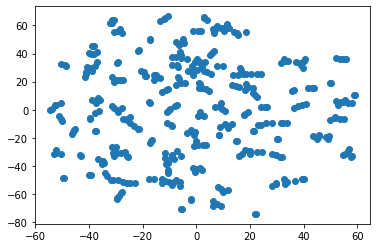

In [522]:
from matplotlib import pyplot as plt

plt.scatter(tsne_tiqqun[:,0], tsne_tiqqun[:,1])

In [523]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(tsne_tiqqun)

In [524]:
sents_indeces = []
for idx, sent in enumerate(sents_tiqqun_short):
    sents_indeces.append((kmeans.labels_[idx], sent, 
                          tsne_tiqqun[idx][0],
                          tsne_tiqqun[idx][1]))

sents_indeces_df = pd.DataFrame(sents_indeces, columns = ['label', 'text', 'embedding_x', 'embedding_y'])

In [525]:
import seaborn as sns

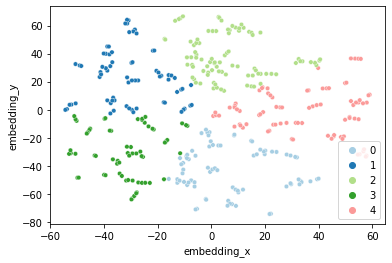

In [526]:
sns.scatterplot(x="embedding_x", y="embedding_y", hue="label", 
                data=sents_indeces_df, palette='Paired', s=20);
plt.legend(loc='lower right');

In [527]:
representative_samples = sents_indeces_df.groupby("label").sample(n=5, random_state=1)
representative_samples.head(10)

,label,text,embedding_x,embedding_y
335,0,"Lawrence,” Critic and Clinic, 1993.",29.546131,-52.187664
376,0,"It is not a substantial quality of beings, but...",-1.960756,-14.069440
254,0,Lawrence that worked out the principles of gue...,33.231613,-50.563435
185,0,"Such a doctrine justified, thirty years later,...",-1.024919,-18.092876
316,0,Speed upholds institutions.,-9.065516,-34.362465
339,1,Simondon thus explains that machines with a hi...,-21.735809,42.077717
203,1,Communism will be a communism of robots!,-27.827278,54.355225
171,1,Be able to keep constraints on the system elem...,-54.397354,0.001339
22,1,What program?,-52.800343,3.604807
197,1,The utopia of a world where machines would wor...,-40.593979,30.593700


In [531]:
for text in representative_samples[representative_samples.label == 4].text:
    print(text)
    print("\n")

It is a way of thinking about balance, born in a crisis context.


Creativity, the social individual, the general intellect - student youth, cultivated dropouts, intangible laborers, etc.


But this strategy implies attacking sedentary forces.


...Homogeneity, mixture, syncretism: this is entropy.


On the one hand the TAZ are defined as “free enclaves,” places whose law is freedom, good things, the Marvelous.




## Your Turn!

NEXT: Explore models at https://huggingface.co/models. Try to run one for yourself. We will help write the helper functions :)